## Detecting Time Series Anomolies

#### Corey Solitaire

`11.05.2020`

In [1]:
import numpy as np
import pandas as pd
import math
from sklearn import metrics

from scipy.stats import entropy

import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import matplotlib.dates as mdates #to format dates on our plots
%matplotlib inline
import seaborn as sns

# This is to make sure matplotlib doesn't throw the following error:
# The next line fixes "TypeError: float() argument must be a string or a number, not 'Timestamp' matplotlib"
pd.plotting.register_matplotlib_converters()

## Wrangle:

#### Read in df

In [2]:
df= pd.read_csv('anonymized-curriculum-access.txt', sep=" ", header=None)
df.head()

,0,1,2,3,4,5
0,2018-01-26,09:55:03,/,1,8.0,97.105.19.61
1,2018-01-26,09:56:02,java-ii,1,8.0,97.105.19.61
2,2018-01-26,09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61
3,2018-01-26,09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61
4,2018-01-26,09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61


In [3]:
df.shape

(719459, 6)

#### Create data frame

In [4]:
df.columns = ['date', 'time', 'page_viewed', 'user_id', 'cohort_id', 'ip']
df["datetime"] = df["date"] + ' '+ df["time"]
df['datetime'] = pd.to_datetime(df.datetime)
df['year'] = df.datetime.dt.year
df['month'] = df.datetime.dt.month
df['day'] = df.datetime.dt.day
df['hour'] = df.datetime.dt.hour
df['weekday'] = df.datetime.dt.day_name()
df = df.astype(object)
df = df.set_index('datetime')
df.drop(columns=['date', 'time'], inplace = True)
df.head()

,page_viewed,user_id,cohort_id,ip,year,month,day,hour,weekday
datetime,,,,,,,,,
2018-01-26 09:55:03,/,1,8,97.105.19.61,2018,1,26,9,Friday
2018-01-26 09:56:02,java-ii,1,8,97.105.19.61,2018,1,26,9,Friday
2018-01-26 09:56:05,java-ii/object-oriented-programming,1,8,97.105.19.61,2018,1,26,9,Friday
2018-01-26 09:56:06,slides/object_oriented_programming,1,8,97.105.19.61,2018,1,26,9,Friday
2018-01-26 09:56:24,javascript-i/conditionals,2,22,97.105.19.61,2018,1,26,9,Friday


In [5]:
df.index.dtype

dtype('<M8[ns]')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 719459 entries, 2018-01-26 09:55:03 to 2020-11-02 16:48:47
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   page_viewed  719458 non-null  object
 1   user_id      719459 non-null  object
 2   cohort_id    674619 non-null  object
 3   ip           719459 non-null  object
 4   year         719459 non-null  object
 5   month        719459 non-null  object
 6   day          719459 non-null  object
 7   hour         719459 non-null  object
 8   weekday      719459 non-null  object
dtypes: object(9)
memory usage: 54.9+ MB


In [7]:
df.describe()

,page_viewed,user_id,cohort_id,ip,year,month,day,hour,weekday
count,719458,719459,674619.0,719459,719459,719459,719459,719459,719459
unique,2153,787,40.0,4339,3,12,31,24,7
top,/,11,28.0,97.105.19.58,2020,8,6,9,Monday
freq,40122,14870,60315.0,284579,297548,82040,26592,103242,147497


In [8]:
df.groupby(['user_id','ip']).sum()

cohort_id    year  month   day  hour  \
user_id ip                                                     
1       12.5.63.210         168.0   12114     54   120    84   
        172.56.15.15         64.0   16144     40    32    91   
        172.56.15.203        24.0    6054      9    57    21   
        172.56.15.46          8.0    2018      5    23     7   
        172.56.15.50         16.0    4036      6    26    14   
...                           ...     ...    ...   ...   ...   
784     99.43.143.116      5673.0  187860    955  1938  1161   
785     24.173.208.242       59.0    2020     10    29    11   
        72.181.127.233     1770.0   60600    309   598   315   
786     72.190.25.232       392.0   14140     70   203   105   
787     99.126.113.140       55.0    2020     10    29    22   

                                                                  weekday  
user_id ip                                                                 
1       12.5.63.210                  FridayFridayFridayFridayFridayFriday  
        172.56.15.15     FridayFridayFridayFridayFridayFridayFridayFriday  
        172.56.15.203                                  MondayMondayMonday  
        172.56.15.46                                            Wednesday  
        172.56.15.50                                       TuesdayTuesday  
...                                                                   ...  
784     99.43.143.116   MondayMondayMondayMondayMondayMondayMondayMond...  
785     24.173.208.242                                           Thursday  
        72.181.127.233  MondayTuesdayTuesdayTuesdayTuesdayTuesdayTuesd...  
786     72.190.25.232   ThursdayThursdayThursdayThursdayThursdayThursd...  
787     99.126.113.140                                           Thursday  

[6182 rows x 6 columns]

In [9]:
df.groupby(['cohort_id','ip']).sum()

user_id    year  month   day  hour  \
cohort_id ip                                                   
1.0       107.204.49.22       248    2018     10     3    10   
          107.77.196.213     1332   18162     90   117   207   
          107.77.217.196      444    6057     15    66    48   
          107.77.217.65      1799   14126     63   105     3   
          107.77.220.6        148    2019      7    14     8   
...                           ...     ...    ...   ...   ...   
62.0      98.199.170.30      1500    4040     20    21    26   
          98.39.66.72       18456   48480    254   312   310   
          99.151.201.25    189992  513080   2508  4923  3394   
          99.162.243.68     96516  254520   1225  2440  1472   
          99.5.223.96        3076    8080     40     7    42   

                                                                    weekday  
cohort_id ip                                                                 
1.0       107.204.49.22                                           Wednesday  
          107.77.196.213  SaturdaySaturdaySaturdaySaturdaySaturdaySaturd...  
          107.77.217.196                        WednesdayWednesdayWednesday  
          107.77.217.65   SaturdaySaturdaySaturdaySaturdaySaturdaySaturd...  
          107.77.220.6                                               Sunday  
...                                                                     ...  
62.0      98.199.170.30                                      SaturdaySunday  
          98.39.66.72     WednesdayWednesdayWednesdayThursdayThursdayThu...  
          99.151.201.25   MondayMondayMondayMondayMondayMondayMondayMond...  
          99.162.243.68   MondayMondayMondayMondayMondayMondayMondayMond...  
          99.5.223.96                            ThursdayFridayFridayFriday  

[4605 rows x 6 columns]

In [10]:
df.groupby('ip').count()

,page_viewed,user_id,cohort_id,year,month,day,hour,weekday
ip,,,,,,,,
100.11.170.135,114,114,114,114,114,114,114,114
100.19.73.35,408,408,408,408,408,408,408,408
100.35.67.162,11,11,11,11,11,11,11,11
103.137.12.164,9,9,9,9,9,9,9,9
103.208.220.130,1,1,0,1,1,1,1,1
...,...,...,...,...,...,...,...,...
99.97.208.13,44,44,44,44,44,44,44,44
99.97.210.12,18,18,18,18,18,18,18,18
99.98.32.165,267,267,267,267,267,267,267,267


In [11]:
df.groupby('weekday').count()

,page_viewed,user_id,cohort_id,ip,year,month,day,hour
weekday,,,,,,,,
Friday,108531,108531,102208,108531,108531,108531,108531,108531
Monday,147497,147497,138495,147497,147497,147497,147497,147497
Saturday,26474,26474,24612,26474,26474,26474,26474,26474
Sunday,38178,38178,35739,38178,38178,38178,38178,38178
Thursday,128828,128828,119923,128828,128828,128828,128828,128828
Tuesday,141750,141750,133135,141750,141750,141750,141750,141750
Wednesday,128200,128201,120507,128201,128201,128201,128201,128201


In [12]:
df.groupby('weekday')['ip'].count()

weekday
Friday       108531
Monday       147497
Saturday      26474
Sunday        38178
Thursday     128828
Tuesday      141750
Wednesday    128201
Name: ip, dtype: int64

In [13]:
#df.groupby('user_id')['weekday'].count()
df.groupby(["weekday", "hour"])["ip"].count()

weekday    hour
Friday     0        825
           1        382
           2        172
           3         65
           4        150
                   ... 
Wednesday  19      2882
           20      3089
           21      3309
           22      2457
           23      1554
Name: ip, Length: 168, dtype: int64

In [14]:
df.groupby('weekday')["user_id"].sum()

weekday
Friday       42618265
Monday       58637327
Saturday     10773116
Sunday       15859701
Thursday     51461159
Tuesday      54851408
Wednesday    48507185
Name: user_id, dtype: int64

In [15]:
#df.groupby('weekday')["ip"].sum()

***

#### Takeaway

`1. Dataset consists of 720,000 hits on the codeup curriculum.  The data consists of a datetime object, the page that was being viewed, the user id, cohort id, and ip address.`

`2. It appears that students are assigned numbers (user_id) and grouped in to cohorts (cohort_id)`

`3. Students often hit the website from different ip addresses, suggesting hits in a variety of locations`

***

## Explore:

***Research Question:***

`1. Characterize use by hour`   
`2. Check for any anamolyous features`   

In [16]:
df.groupby('hour')['ip'].count()

hour
0       4988
1       2674
2       1590
3        854
4        937
5       1540
6       3411
7       9079
8      41262
9     103242
10     71375
11     73834
12     39596
13     61157
14     72474
15     66387
16     53282
17     18592
18     15239
19     16121
20     18141
21     18528
22     15242
23      9914
Name: ip, dtype: int64

`1. Most hits observed at 9 am and tapirs off after that`   
`2. After 4 pm activity drops to about 1500 hits`   
`3. Lowest number of hits observed at 3am`   

***

#### Lets look at the ip data for only 3 am

***

In [17]:
df.head(1)

,page_viewed,user_id,cohort_id,ip,year,month,day,hour,weekday
datetime,,,,,,,,,
2018-01-26 09:55:03,/,1,8,97.105.19.61,2018,1,26,9,Friday


In [18]:
three_am=df[df.hour == 3]
three_am.head()

,page_viewed,user_id,cohort_id,ip,year,month,day,hour,weekday
datetime,,,,,,,,,
2018-02-01 03:56:33,/,48,NaN,66.69.62.219,2018,2,1,3,Thursday
2018-02-07 03:14:00,java-ii/object-oriented-programming,48,NaN,66.69.62.219,2018,2,7,3,Wednesday
2018-02-07 03:14:02,slides/object_oriented_programming,48,NaN,66.69.62.219,2018,2,7,3,Wednesday
2018-02-07 03:14:21,java-ii/interfaces-and-abstract-classes,48,NaN,66.69.62.219,2018,2,7,3,Wednesday
2018-02-07 03:14:22,slides/interfaces_and_abstract_classes,48,NaN,66.69.62.219,2018,2,7,3,Wednesday


#### Change formatting of IP address

In [19]:
# Function I found Online
def ip_to_int(ip_ser):
    ips = ip_ser.str.split('.', expand=True).astype(np.int16).values
    mults = np.tile(np.array([24, 16, 8, 0]), len(ip_ser)).reshape(ips.shape)
    return np.sum(np.left_shift(ips, mults), axis=1)

In [20]:
three_am['int_ip'] = ip_to_int(three_am.ip)
three_am.head()

,page_viewed,user_id,cohort_id,ip,year,month,day,hour,weekday,int_ip
datetime,,,,,,,,,,
2018-02-01 03:56:33,/,48,NaN,66.69.62.219,2018,2,1,3,Thursday,1111834331
2018-02-07 03:14:00,java-ii/object-oriented-programming,48,NaN,66.69.62.219,2018,2,7,3,Wednesday,1111834331
2018-02-07 03:14:02,slides/object_oriented_programming,48,NaN,66.69.62.219,2018,2,7,3,Wednesday,1111834331
2018-02-07 03:14:21,java-ii/interfaces-and-abstract-classes,48,NaN,66.69.62.219,2018,2,7,3,Wednesday,1111834331
2018-02-07 03:14:22,slides/interfaces_and_abstract_classes,48,NaN,66.69.62.219,2018,2,7,3,Wednesday,1111834331


In [21]:
three_am.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 854 entries, 2018-02-01 03:56:33 to 2020-11-01 03:03:30
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   page_viewed  854 non-null    object
 1   user_id      854 non-null    object
 2   cohort_id    791 non-null    object
 3   ip           854 non-null    object
 4   year         854 non-null    object
 5   month        854 non-null    object
 6   day          854 non-null    object
 7   hour         854 non-null    object
 8   weekday      854 non-null    object
 9   int_ip       854 non-null    int64 
dtypes: int64(1), object(9)
memory usage: 73.4+ KB


In [22]:
# three_am = three_am[['ip']]

In [27]:
# three_am['ip_count'] = three_am.resample("1D").count()
# gapminder['lifeExp_mean'] = gapminder.groupby('continent').lifeExp.transform('mean')

NameError: name 'ip_count' is not defined

#### Resample By Day 

In [29]:
df_3 = three_am.resample("1D").count()
df_3

,ip
datetime,
2018-02-01,1
2018-02-02,0
2018-02-03,0
2018-02-04,0
2018-02-05,0
...,...
2020-10-28,0
2020-10-29,0
2020-10-30,1


#### Visualize Data

<Figure size 864x576 with 0 Axes>

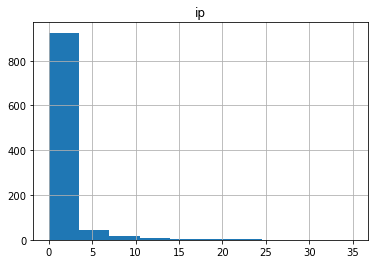

In [31]:
plt.figure(figsize=(12, 8))
df3.hist()
plt.show()

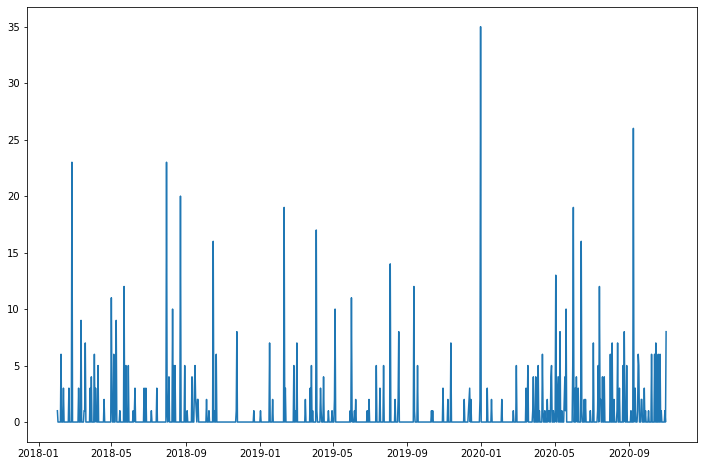

In [32]:
# Visualize Splits (Sanity Check)
x = df3.index
y = df3.ip

plt.figure(figsize=(12, 8))
plt.plot(x,y)
plt.show()

`It appears that the general trend in hits at 3am has increased over time, and it appears that creating some Bollinger bands may help to distinguish outliers`

#### Resample Data

In [ ]:
# df.resample('H').count()

In [ ]:
# df.head(1)

In [ ]:
# df.tail(1)

#### Split into Train/Test

In [ ]:
# # 506 Days (.5)
# train = df[:'2019-06-16']
# # 303 Days (.3)
# validate = df['2019-06-15':'2020-04-15']
# # 202 Days (.2)
# test = df['2020-04-16':]

In [ ]:
# # Visualize Splits (Sanity Check)
# plt.figure(figsize=(12, 8))
# plt.plot(train)
# plt.plot(validate)
# plt.plot(test)
# plt.show()

In [ ]:
#